<a href="https://colab.research.google.com/github/thanaphornkanking/Project/blob/main/Train_id2_id6_id10_test_id_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd # ใช้ทำงานกับข้อมูลลักษณะตาราง

In [2]:
from google.colab import drive # เชื่อมบัญชีกับ google drive
drive.mount('/content/drive') # เช็คว่าเชื่อมติดหรือไม่

Mounted at /content/drive


In [3]:
ls

drive/  sample_data/


# load model

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [5]:
batch_size = 20 #จำนวนตัวอย่างที่ใช้ในแต่ละการฝึกโมเดล (batch) คือ 20 ตัวอย่างต่อการฝึกหนึ่งครั้ง
width = 150 #ขนาดของภาพที่นำเข้าเพื่อฝึกโมเดล มีความกว้างและความสูงเท่ากับ 150 พิกเซล.
height = 150
epochs = 100 #จำนวนรอบการฝึกโมเดลทั้งหมดที่ทำในขั้นตอนการฝึก คือ 100 รอบ.
NUM_TRAIN = 100 #จำนวนตัวอย่างที่ใช้สำหรับฝึกและทดสอบโมเดล คือ 100 ตัวอย่างสำหรับแต่ละกระบวนการ.
NUM_TEST = 100
dropout_rate = 0.2 #อัตราการลดการสุ่มตัวอย่างในชั้น Dropout ที่ใช้เพื่อลดการเรียนรู้เกินไปของโมเดล คือ 0.2 หมายถึง 20% ของการสุ่มตัวอย่างที่จะถูกลบทิ้ง.
input_shape = (height, width, 3)#รูปแบบของข้อมูลที่นำเข้า (input shape) สำหรับโมเดล คือ ภาพสีที่มีความกว้าง 150 พิกเซล ความสูง 150 พิกเซล และ 3 ช่องสี (RGB)

In [6]:
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

#เอาโมเดลมาใช้

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 19.77 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


In [7]:
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [8]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

16717576/16717576 [==============================] - 0s 0us/step


In [9]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 75, 75, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 75, 75, 32)           0         ['batch_normaliz

# Import data

In [10]:
import pandas as pd
import shutil

In [11]:
df = pd.read_csv (r'/content/drive/MyDrive/รูปรถทั้งหมด(old)/id_all_car.csv')
df

,no,id,Degree,part,Path_Name
0,1,id2,Base,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id2/B...
1,2,id2,Base,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id2/B...
2,3,id2,Base,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id2/B...
3,4,id2,Base,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id2/B...
4,5,id2,Base,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id2/B...
...,...,...,...,...,...
192658,192659,id12,Base,p15,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id12/...
192659,192660,id12,Base,p15,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id12/...
192660,192661,id12,Base,p15,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id12/...
192661,192662,id12,Base,p15,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id12/...


# แบ่งข้อมูล Train & Test

In [12]:
train = df[df['no'].between(0,189089)]
test = df[df['no'].between(189090,192662)]

In [13]:
DATA_PATH = "/content/drive/MyDrive/id"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
test_dir = os.path.join(DATA_PATH, 'test')
print(test_dir)

/content/drive/MyDrive/id/train
/content/drive/MyDrive/id/test


# ตั้งค่า Train

In [14]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'Path_Name',
        y_col = 'Degree',
        target_size=(height, width),
        batch_size=batch_size)

test_generator = test_datagen.flow_from_dataframe(
        dataframe = test,
        directory = test_dir,
        x_col = 'Path_Name',
        y_col = 'Degree',
        target_size=(height, width),
        batch_size=batch_size)

Found 189089 validated image filenames belonging to 4 classes.
Found 3573 validated image filenames belonging to 4 classes.


# load model (เดิมมาเทรนต่อ)

In [16]:
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
/content/efficientnet_keras_transfer_learning


In [17]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(4, activation='softmax', name="fc_out"))

In [18]:
model.summary() #ของ conv_base

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 5, 5, 1280)        4049564   
 l)                                                              
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 4)                 5124      
                                                                 
Total params: 4054688 (15.47 MB)
Trainable params: 4012672 (15.31 MB)
Non-trainable params: 42016 (164.12 KB)
_________________________________________________________________


In [19]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [20]:
model.summary() #ของ freez

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 5, 5, 1280)        4049564   
 l)                                                              
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 4)                 5124      
                                                                 
Total params: 4054688 (15.47 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


# เริ่ม training

In [21]:
import tensorflow as tf

In [22]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=['acc']
)
history = model.fit(
    train_generator,
    steps_per_epoch=NUM_TRAIN // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=NUM_TEST // batch_size,
    verbose=1,
    use_multiprocessing=True,
    workers=4
)

Epoch 1/100


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


5/5 [==============================] - 49s 8s/step - loss: 3.4276 - acc: 0.1900 - val_loss: 2.4862 - val_acc: 0.3100
Epoch 2/100
5/5 [==============================] - 26s 5s/step - loss: 2.8348 - acc: 0.3100 - val_loss: 2.8153 - val_acc: 0.2600
Epoch 3/100
5/5 [==============================] - 42s 9s/step - loss: 3.2233 - acc: 0.2300 - val_loss: 2.9216 - val_acc: 0.2400
Epoch 4/100
5/5 [==============================] - 43s 9s/step - loss: 2.9227 - acc: 0.2200 - val_loss: 2.3964 - val_acc: 0.1900
Epoch 5/100
5/5 [==============================] - 32s 6s/step - loss: 2.8897 - acc: 0.2300 - val_loss: 2.3129 - val_acc: 0.2700
Epoch 6/100
5/5 [==============================] - 36s 7s/step - loss: 2.4864 - acc: 0.3200 - val_loss: 2.3708 - val_acc: 0.3300
Epoch 7/100
5/5 [==============================] - 34s 7s/step - loss: 2.1824 - acc: 0.2900 - val_loss: 2.5491 - val_acc: 0.1800
Epoch 8/100
5/5 [==============================] - 71s 16s/step - loss: 3.0168 - acc: 0.2500 - val_loss: 2.56

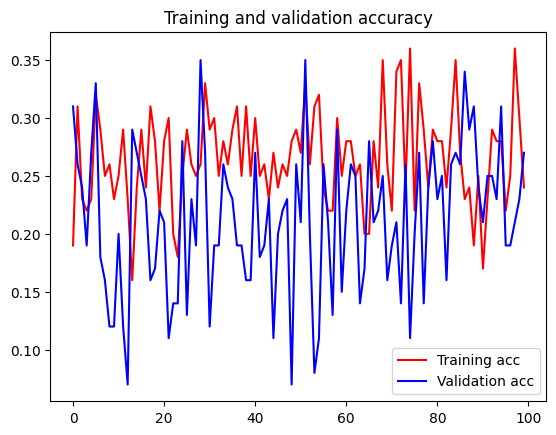

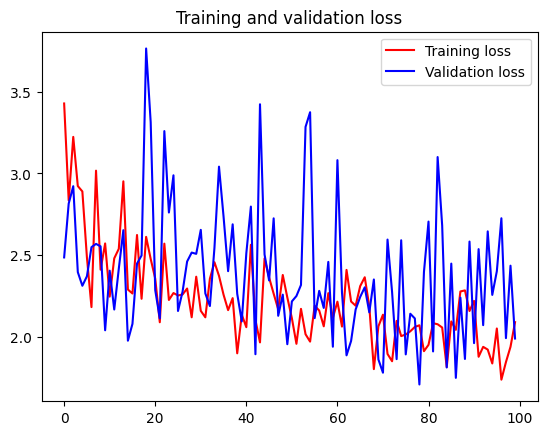

In [23]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'r', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'r', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# save model

In [24]:
os.makedirs('/content/drive/MyDrive/Model', exist_ok=True)
model.save('/content/drive/My Drive/Model/100_(damage)_Train_id2_id6_id8_id10_Test_id12.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
